
# 🔥 PyTorch Part 6:  Computer Vision

**Goal:** Build, train, and evaluate several image classifiers (from a linear baseline to transfer learning) on **CIFAR‑10**.

---

**What you’ll build**
- Data pipeline (datasets, transforms, dataloaders, augmentation)
- Device‑agnostic training utilities (GPU/CPU)
- **Model A:** Linear baseline (just `Flatten + Linear`)
- **Model B:** MLP (non-linearities)
- **Model C:** Simple CNN
- **Model D:** Transfer Learning with `torchvision.models.resnet18`
- Metrics & visualizations (accuracy, confusion matrix)
- Save / load best model
- Predict on random test images **and** your own uploaded images





In [1]:
import torch, torchvision, matplotlib, sys, platform
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print(f"PyTorch: {torch.__version__}")
print(f"TorchVision: {torchvision.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


PyTorch: 2.8.0+cu126
TorchVision: 0.23.0+cu126
Matplotlib: 3.10.0
CUDA available: True


device(type='cuda')

In [2]:

#@title 1. Reproducibility & Small Helpers
from timeit import default_timer as timer
import random, numpy as np

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

def print_train_time(start: float, end: float, device: torch.device):
    t = end - start
    print(f"⏱️ Train time on {device}: {t:.2f} sec")
    return t

def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    return (y_true == y_pred).float().mean().item() * 100



## 2. Data, Transforms, and DataLoaders (CIFAR‑10)

CIFAR‑10 has **60k color images** (32x32, 3 channels) across **10 classes**:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

We'll create **train** and **test** datasets with:
- basic `ToTensor()` + normalization
- light **augmentation** for training


In [3]:

#@title 2.1 Create datasets & dataloaders
# CIFAR-10 stats commonly used for normalization
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

data_root = "data"
train_data = datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tfms)
test_data  = datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)

class_names = train_data.classes
len(train_data), len(test_data), class_names


100%|██████████| 170M/170M [00:03<00:00, 45.8MB/s]


(50000,
 10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

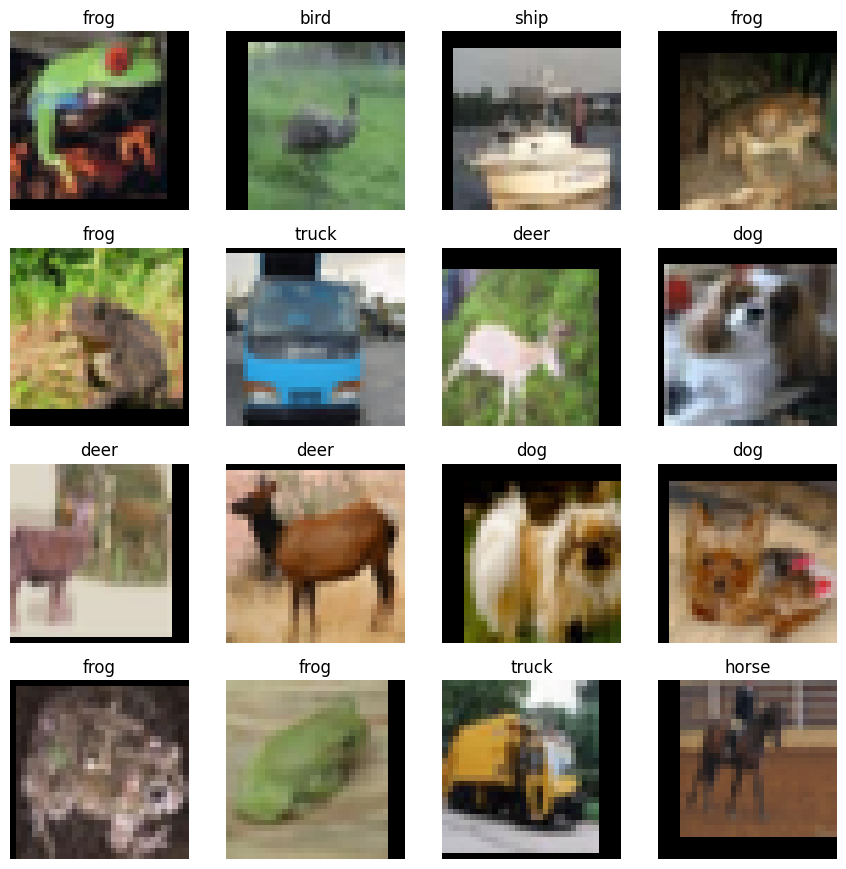

In [4]:

#@title 2.2 Visualize a few training samples (unnormalized view)
# We'll visualize a handful of unnormalized images by inverse-normalizing for plotting.
inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip(CIFAR10_MEAN, CIFAR10_STD)],
    std=[1/s for s in CIFAR10_STD],
)

def show_batch(dataset, n=16):
    idxs = torch.randperm(len(dataset))[:n]
    cols = int(n**0.5)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(2.2*cols, 2.2*rows))
    for i, idx in enumerate(idxs, 1):
        x, y = dataset[idx]
        x = inv_norm(x).clamp(0,1)  # inverse normalize for display
        plt.subplot(rows, cols, i)
        plt.imshow(np.transpose(x.numpy(), (1,2,0)))
        plt.title(class_names[y])
        plt.axis("off")
    plt.tight_layout()

show_batch(train_data, n=16)


In [5]:

#@title 2.3 Build DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_loader), len(test_loader)


(391, 79)


## 3. Training & Evaluation Utilities (device-agnostic)

We’ll write reusable, concise loops for training & evaluation.


In [6]:

#@title 3.1 Train & Test steps
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        running_acc  += (preds == y).float().sum().item()
        n += X.size(0)
    return running_loss / n, (running_acc / n) * 100

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    running_loss, running_acc, n = 0.0, 0.0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        running_acc  += (preds == y).float().sum().item()
        n += X.size(0)
    return running_loss / n, (running_acc / n) * 100

def fit(model, train_loader, test_loader, optimizer, loss_fn, epochs=5, device=device):
    model.to(device)
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    start = timer()
    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        te_loss, te_acc = evaluate(model, test_loader, loss_fn, device)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["test_loss"].append(te_loss);  history["test_acc"].append(te_acc)
        print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.2f}% | test loss {te_loss:.4f} acc {te_acc:.2f}%")
    dur = print_train_time(start, timer(), device)
    return history, dur



## 4. Model A — Linear Baseline

A fast baseline: **Flatten → Linear(3072 → 10)** on 32x32x3 images.


In [7]:

#@title 4.1 Define & train Linear
class LinearBaseline(nn.Module):
    def __init__(self, in_features=3*32*32, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        return self.net(x)

set_seed(42)
model_a = LinearBaseline().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_a.parameters(), lr=0.1)
hist_a, time_a = fit(model_a, train_loader, test_loader, optimizer, loss_fn, epochs=5, device=device)


Epoch 01 | train loss 17.1433 acc 20.21% | test loss 16.1983 acc 21.99%
Epoch 02 | train loss 16.0337 acc 21.18% | test loss 31.0376 acc 17.91%
Epoch 03 | train loss 15.9303 acc 21.61% | test loss 13.8862 acc 23.14%
Epoch 04 | train loss 16.0154 acc 21.82% | test loss 20.1534 acc 21.71%
Epoch 05 | train loss 15.8279 acc 21.90% | test loss 18.5275 acc 25.38%
⏱️ Train time on cuda: 88.29 sec



## 5. Model B — MLP (Non‑Linearities)

Introduce capacity with hidden layers and ReLUs.


In [8]:

#@title 5.1 Define & train MLP
class MLP(nn.Module):
    def __init__(self, in_features=3*32*32, hidden=256, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes),
        )
    def forward(self, x):
        return self.net(x)

set_seed(42)
model_b = MLP().to(device)
optimizer = torch.optim.SGD(model_b.parameters(), lr=0.1, momentum=0.9, nesterov=True)
hist_b, time_b = fit(model_b, train_loader, test_loader, optimizer, loss_fn, epochs=10, device=device)


Epoch 01 | train loss 1.9924 acc 27.93% | test loss 2.0711 acc 22.08%
Epoch 02 | train loss 1.9880 acc 28.08% | test loss 2.1054 acc 22.16%
Epoch 03 | train loss 1.9913 acc 28.65% | test loss 2.0956 acc 24.51%
Epoch 04 | train loss 1.9971 acc 28.44% | test loss 2.1567 acc 17.29%
Epoch 05 | train loss 2.0032 acc 27.74% | test loss 2.1397 acc 19.81%
Epoch 06 | train loss 1.9823 acc 28.47% | test loss 2.1908 acc 18.37%
Epoch 07 | train loss 1.9814 acc 28.72% | test loss 2.1561 acc 21.11%
Epoch 08 | train loss 1.9938 acc 27.68% | test loss 2.1751 acc 18.78%
Epoch 09 | train loss 1.9920 acc 28.13% | test loss 2.2121 acc 18.18%
Epoch 10 | train loss 2.0032 acc 27.50% | test loss 2.1924 acc 17.21%
⏱️ Train time on cuda: 178.36 sec



## 6. Model C — Simple CNN

A compact ConvNet suitable for 32x32 images.


In [9]:

#@title 6.1 Define & train CNN
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

set_seed(42)
model_c = SmallCNN().to(device)
optimizer = torch.optim.Adam(model_c.parameters(), lr=1e-3)
hist_c, time_c = fit(model_c, train_loader, test_loader, optimizer, loss_fn, epochs=10, device=device)


Epoch 01 | train loss 1.6412 acc 39.37% | test loss 1.3343 acc 52.60%
Epoch 02 | train loss 1.2350 acc 55.45% | test loss 1.1033 acc 60.19%
Epoch 03 | train loss 1.0099 acc 64.19% | test loss 0.8605 acc 69.66%
Epoch 04 | train loss 0.8805 acc 68.95% | test loss 0.7626 acc 73.30%
Epoch 05 | train loss 0.7868 acc 72.46% | test loss 0.7480 acc 74.21%
Epoch 06 | train loss 0.7294 acc 74.49% | test loss 0.6780 acc 76.38%
Epoch 07 | train loss 0.6687 acc 76.55% | test loss 0.6590 acc 77.37%
Epoch 08 | train loss 0.6264 acc 78.11% | test loss 0.6367 acc 78.51%
Epoch 09 | train loss 0.5995 acc 78.92% | test loss 0.5934 acc 79.98%
Epoch 10 | train loss 0.5687 acc 80.18% | test loss 0.5988 acc 79.45%
⏱️ Train time on cuda: 202.16 sec



## 7. Model D — Transfer Learning (ResNet18)

Use a pretrained backbone and fine‑tune the final layer for CIFAR‑10.


In [10]:

#@title 7.1 Define & train Transfer Learning model
from torchvision import models

set_seed(42)
model_d = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Replace first conv for small inputs? We'll just upsample images via transforms if needed.
# Replace classifier head
model_d.fc = nn.Linear(model_d.fc.in_features, 10)
model_d = model_d.to(device)

# Slightly different transforms for this model: resize to 224 on-the-fly via an upsample layer.
# We'll wrap the model to include a resize when needed.
class ResizeWrapper(nn.Module):
    def __init__(self, model, size=224):
        super().__init__()
        self.model = model
        self.upsample = nn.Upsample(size=(size, size), mode="bilinear", align_corners=False)
    def forward(self, x):
        return self.model(self.upsample(x))

model_d = ResizeWrapper(model_d).to(device)

optimizer = torch.optim.AdamW(model_d.parameters(), lr=1e-4, weight_decay=1e-4)
hist_d, time_d = fit(model_d, train_loader, test_loader, optimizer, loss_fn, epochs=5, device=device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Epoch 01 | train loss 0.3808 acc 87.56% | test loss 0.2071 acc 92.91%
Epoch 02 | train loss 0.1595 acc 94.71% | test loss 0.1756 acc 93.88%
Epoch 03 | train loss 0.1069 acc 96.43% | test loss 0.1693 acc 94.43%
Epoch 04 | train loss 0.0794 acc 97.39% | test loss 0.1703 acc 94.47%
Epoch 05 | train loss 0.0629 acc 97.88% | test loss 0.1548 acc 95.13%
⏱️ Train time on cuda: 754.10 sec



## 8. Compare Models

Let's summarize accuracy and training time.


,model,test_acc,time_s
0,ResNet18 TL,95.13,754.098755
1,CNN,79.45,202.162934
2,Linear,25.38,88.286650
3,MLP,17.21,178.359421


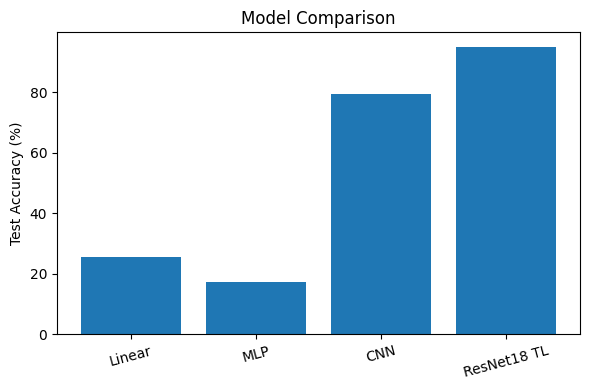

In [11]:

#@title 8.1 Results table + bar chart
import pandas as pd

def last(d, k):
    return d[k][-1] if len(d[k]) else float('nan')

results = pd.DataFrame([
    {"model":"Linear", "test_acc": last(hist_a,"test_acc"), "time_s": time_a},
    {"model":"MLP",    "test_acc": last(hist_b,"test_acc"), "time_s": time_b},
    {"model":"CNN",    "test_acc": last(hist_c,"test_acc"), "time_s": time_c},
    {"model":"ResNet18 TL", "test_acc": last(hist_d,"test_acc"), "time_s": time_d},
])

display(results.sort_values("test_acc", ascending=False).reset_index(drop=True))

# Plot accuracy (matplotlib; no specific colors)
plt.figure(figsize=(6,4))
plt.bar(results["model"], results["test_acc"])
plt.ylabel("Test Accuracy (%)")
plt.title("Model Comparison")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



## 9. Confusion Matrix

Where does the best model get confused?


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.5 MB/s eta 0:00:00
Best model: ResNet18 TL


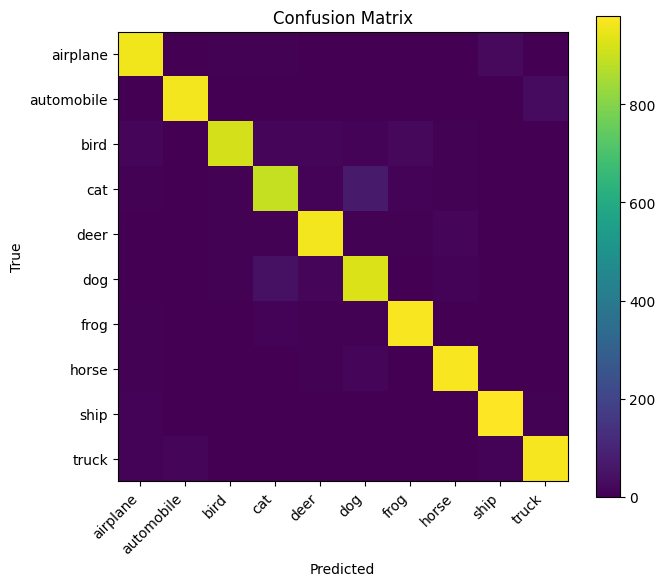

In [13]:

#@title 9.1 Build confusion matrix with torchmetrics (no seaborn)
# Pick the best (highest test_acc) model
!pip install -q torchmetrics
import torchmetrics
best_name = results.sort_values("test_acc", ascending=False)["model"].iloc[0]
print("Best model:", best_name)

name_to_model = {
    "Linear": model_a,
    "MLP": model_b,
    "CNN": model_c,
    "ResNet18 TL": model_d,
}
best_model = name_to_model[best_name].to(device)
best_model.eval()

import torchmetrics
num_classes = 10
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

all_preds, all_targets = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        logits = best_model(X)
        preds = logits.argmax(dim=1)
        all_preds.append(preds)
        all_targets.append(y)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)
cm = confmat(all_preds, all_targets).cpu().numpy()

# Plot as image (matplotlib)
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xticks(ticks=range(num_classes), labels=class_names, rotation=45, ha='right')
plt.yticks(ticks=range(num_classes), labels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()



## 10. Save & Load the Best Model


In [14]:

#@title 10.1 Save & reload
from pathlib import Path
save_dir = Path("saved_models")
save_dir.mkdir(exist_ok=True, parents=True)
model_path = save_dir / f"best_{best_name.replace(' ', '_').lower()}.pt"

torch.save(best_model.state_dict(), model_path)
print("Saved to:", model_path)

# Reload (recreate matching architecture)
def recreate(model_name: str):
    if model_name == "Linear":
        m = LinearBaseline()
    elif model_name == "MLP":
        m = MLP()
    elif model_name == "CNN":
        m = SmallCNN()
    elif model_name == "ResNet18 TL":
        base = models.resnet18(weights=None)
        base.fc = nn.Linear(base.fc.in_features, 10)
        m = ResizeWrapper(base)
    else:
        raise ValueError("Unknown model")
    return m

reloaded = recreate(best_name).to(device)
reloaded.load_state_dict(torch.load(model_path, map_location=device))
reloaded.eval()

# Quick sanity check
_, acc_reload = evaluate(reloaded, test_loader, loss_fn, device)
print(f"Reloaded test acc: {acc_reload:.2f}%")


Saved to: saved_models/best_resnet18_tl.pt
Reloaded test acc: 95.13%



## 11. Make Predictions (Random & Your Own Images)

- Visualize random test predictions.
- Upload your own `.jpg/.png` images (Colab: runs a file picker).


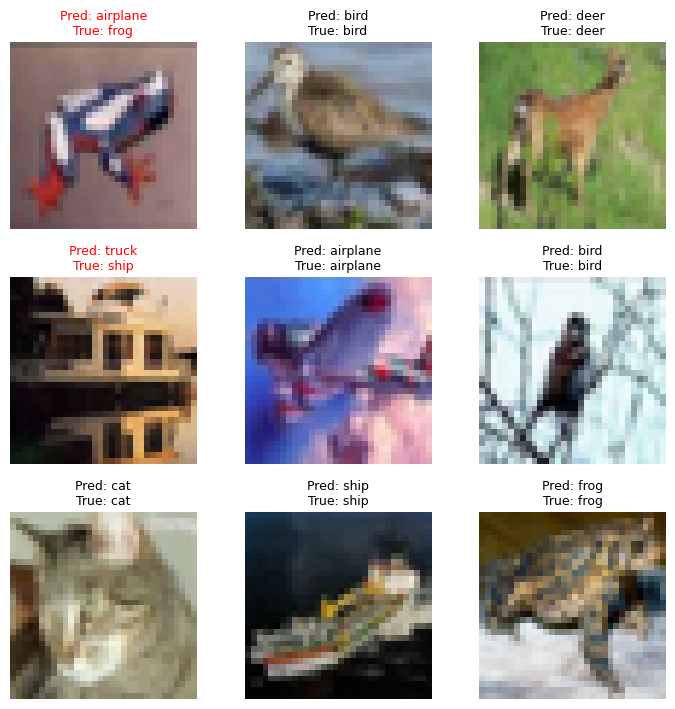

In [15]:

#@title 11.1 Random test predictions
@torch.no_grad()
def predict_and_plot(model, dataset, n=9):
    idxs = torch.randperm(len(dataset))[:n]
    cols = int(n**0.5)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(2.4*cols, 2.4*rows))
    for i, idx in enumerate(idxs, 1):
        x, y = dataset[idx]
        x_in = x.unsqueeze(0).to(device)
        logits = model(x_in)
        pred = logits.argmax(dim=1).item()

        x_show = inv_norm(x).clamp(0,1).permute(1,2,0).cpu().numpy()
        plt.subplot(rows, cols, i)
        plt.imshow(x_show)
        title = f"Pred: {class_names[pred]}\nTrue: {class_names[y]}"
        c = "k" if pred == y else "r"
        plt.title(title, color=c, fontsize=9)
        plt.axis("off")
    plt.tight_layout()

predict_and_plot(best_model, test_data, n=9)


Saving airplane.jpg to airplane.jpg


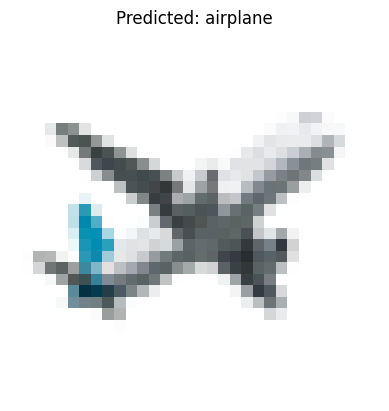

In [16]:

#@title 11.2 Your images (Colab upload)
# If you're running this in Colab, you can upload images and get predictions.
try:
    from google.colab import files
    import PIL.Image as Image
    import io

    uploaded = files.upload()  # pick images
    for fname, content in uploaded.items():
        img = Image.open(io.BytesIO(content)).convert("RGB").resize((32,32))
        x = transforms.ToTensor()(img)
        x = transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)(x)
        with torch.no_grad():
            logits = best_model(x.unsqueeze(0).to(device))
            pred = logits.argmax(dim=1).item()
        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted: {class_names[pred]}")
        plt.axis("off")
        plt.show()
except Exception as e:
    print("Upload not available here. Run in Google Colab to use the file picker.")
    print("Error:", e)



## 12. Wrap‑Up & Next Steps

**What you practiced**
- Loading & augmenting image data
- Writing clean, device‑agnostic training loops
- Comparing models (Linear → MLP → CNN → Transfer Learning)
- Evaluating with accuracy & confusion matrix
- Saving / reloading models
- Making predictions on custom images

**Ideas to extend**
- Try stronger augmentation (`ColorJitter`, `RandomErasing`).
- Add a learning rate scheduler and early stopping.
- Increase CNN depth or try other backbones (`efficientnet_b0`, `mobilenet_v3_small`).
- Track metrics with TensorBoard or Weights & Biases.
- Export the best model to TorchScript for deployment.

---

### Exercises
1) Replace SGD/Adam with `AdamW` across all models and compare.
2) Add `CosineAnnealingLR` or `OneCycleLR` and compare.
3) Train with mixed precision (`torch.cuda.amp.autocast`) and measure speed.
4) Create a **confusion pairs** gallery: show images for the most confused classes.
5) Fine‑tune more layers of ResNet18 (unfreeze last 2 blocks) and compare.

Happy building! 🚀
